## Plot ACF/PACF for process models to illustrate

### Preliminaries

Make sure that you have activated your `stisp` environment, defined for conda installation in the `environment.yml` file of this repository.  All of the packages we import here should be available within that environment.

In [1]:
from sklearn.covariance import GraphicalLassoCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.linalg
import glob

Adjust matplotlib default settings for plot label sizes and color scheme:

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

noise_colors=cm.get_cmap('Blues')

/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_75249/2752885123.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  noise_colors=cm.get_cmap('Blues')


We do all of our stochastic fitting to the output from individual process models, because fitting a multi-model mean would damp out some of the variability that we want to capture.  Data is aggregated to catchments defined by Mouginot & Rignot (link), tagged with ID numbers consistent with that dataset.  Here we select a process model to analyse and a glacier catchment to examine.

In [42]:
model_names = ['ANICE-ITM_Berends', 'CESM_kampenhout', 'dEBM_krebs','HIRHAM_mottram', 
                'NHM-SMAP_niwano', 'RACMO_noel', 'SNOWMODEL_liston']

highlight_model = model_names[0]
highlight_catchment_name, highlight_catchment_id = 'KANGERLUSSUAQ', 101

## Specify filepath pattern of series.  
## This will be fed to glob later (hence *) 
## and looped over catchment number (hence {} awaiting .format())
series_path = '/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP-processed/*-catchment_{}_mean-tseries.csv'

Use helper function  `read_catchment_series` to read in our aggregated data from CSV.

In [4]:
## Read in time series
def read_catchment_series(fpath, anomaly=True):
    catchment_fpath = fpath
    catchment_tseries = pd.read_csv(catchment_fpath, index_col=0, parse_dates=[0])
    catchment_tseries.mask(catchment_tseries>1e30)
    anomaly_series = catchment_tseries - catchment_tseries.mean()
    if anomaly:
        return anomaly_series
    else:
        return catchment_tseries

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

We ignore warnings for now, because statsmodels is going to complain about parameter names.  This does not affect our results.  If you are debugging and want to see warnings, you can set `action=once` instead.

In [43]:
## Read in time series and report ACF/PACF
mod_fits = {m: [] for m in model_names}
mods = {m: [] for m in model_names}

ctmt_fpath = glob.glob(series_path.format(highlight_catchment_id))[0]
s = read_catchment_series(ctmt_fpath, anomaly=True)
a = s.resample('A').sum()

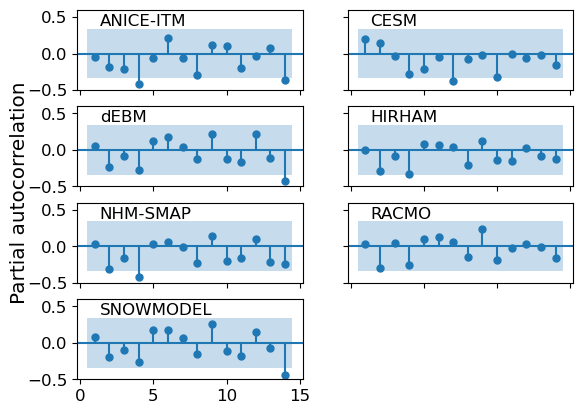

In [44]:
import matplotlib as mpl
from matplotlib.patches import Patch
mpl.rcParams['legend.frameon'] = 'False'


fig, axs = plt.subplots(4,2, sharey=True, sharex=True)
for i, m in enumerate(model_names):
    ax = axs.ravel()[i]
    plot_pacf(a[m], lags=14, ax=ax, title=None, zero=False)
#     ax.hist(Ns_annual_bymodel[m], bins=range(0,6))
    ax.set(ylim=(-0.5, 0.6)
            )
    
    ax.text(0.1, 0.8, m.split('_')[0], transform=ax.transAxes)
    # ## custom legend to add annotation
    # legend_elements = [Patch(facecolor=None, edgecolor=None,visible=False,label=m.split('_')[0]),
    #                   # Patch(facecolor=None, edgecolor=None,
    #                   #       visible=False,label=r'# $n>0$: {}'.format(non0_count_m)),
    #                   #   Patch(facecolor=None, edgecolor=None,
    #                   #         visible=False,label=r'Avg. $\Delta$BIC: {:.2f}'.format(bic_diff))
    #                   ] 

#     ax.legend(handles=legend_elements, loc='upper right')
axs[-1,-1].axis('off')
fig.supylabel('Partial autocorrelation')
plt.show()  

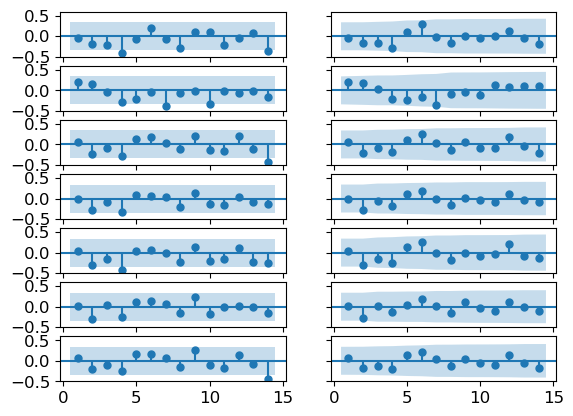

In [58]:
fig2, axs = plt.subplots(7,2, sharey=True, sharex=True)
for i, m in enumerate(model_names):
    ax1 = axs[i][0]
    ax2 = axs[i][1]
    plot_pacf(a[m], lags=14, ax=ax1, title=None, zero=False)
    plot_acf(a[m], lags=14, ax=ax2, title=None, zero=False)
    ax1.set(ylim=(-0.5, 0.6),
            )
    ax2.set(ylim=(-0.5, 0.6),
            )
    
    # ax1.text(0.1, 0.8, m.split('_')[0], transform=ax1.transAxes)
    ## custom legend to add annotation
#     legend_elements = [Patch(facecolor=None, edgecolor=None,visible=False,label=m.split('_')[0]),
#                       # Patch(facecolor=None, edgecolor=None,
#                       #       visible=False,label=r'# $n>0$: {}'.format(non0_count_m)),
#                       #   Patch(facecolor=None, edgecolor=None,
#                       #         visible=False,label=r'Avg. $\Delta$BIC: {:.2f}'.format(bic_diff))
#                       ] 

#     ax1.legend(handles=legend_elements, loc='upper right')
# axs[-1,-1].axis('off')
# fig.supylabel('Partial autocorrelation')
# fig2.tight_layout()
plt.show()  